### LSTM-based Recurrent Neural Network (RNN) to predict SBIN (State Bank of India) stock price

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nifty50-stock-market-data/HDFCBANK.csv
/kaggle/input/nifty50-stock-market-data/GRASIM.csv
/kaggle/input/nifty50-stock-market-data/WIPRO.csv
/kaggle/input/nifty50-stock-market-data/stock_metadata.csv
/kaggle/input/nifty50-stock-market-data/BPCL.csv
/kaggle/input/nifty50-stock-market-data/INFY.csv
/kaggle/input/nifty50-stock-market-data/LT.csv
/kaggle/input/nifty50-stock-market-data/RELIANCE.csv
/kaggle/input/nifty50-stock-market-data/BRITANNIA.csv
/kaggle/input/nifty50-stock-market-data/INFRATEL.csv
/kaggle/input/nifty50-stock-market-data/HEROMOTOCO.csv
/kaggle/input/nifty50-stock-market-data/HINDUNILVR.csv
/kaggle/input/nifty50-stock-market-data/TATAMOTORS.csv
/kaggle/input/nifty50-stock-market-data/MM.csv
/kaggle/input/nifty50-stock-market-data/HDFC.csv
/kaggle/input/nifty50-stock-market-data/JSWSTEEL.csv
/kaggle/input/nifty50-stock-market-data/TITAN.csv
/kaggle/input/nifty50-stock-market-data/HINDALCO.csv
/kaggle/input/nifty50-stock-market-data/AXISBANK.csv
/kaggle/inpu

In [4]:
### Importing Required Libraries ###

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

**Reading SBIN data from NIFTY 50 dataset**

In [5]:
#read the file
df = pd.read_csv("../input/nifty50-stock-market-data/WIPRO.csv")

#print the head
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,WIPRO,EQ,2522.40,2724.00,2724.20,2724.00,2724.20,2724.20,2724.17,1599,4.355942e+11,NaN,NaN,NaN
1,2000-01-04,WIPRO,EQ,2724.20,2942.15,2942.15,2942.15,2942.15,2942.15,2942.15,4392,1.292192e+12,NaN,NaN,NaN
2,2000-01-05,WIPRO,EQ,2942.15,2942.15,3177.55,2715.00,3000.00,2990.10,3063.86,132297,4.053390e+13,NaN,NaN,NaN
3,2000-01-06,WIPRO,EQ,2990.10,3144.70,3183.00,2790.00,2915.00,2932.25,2962.41,72840,2.157822e+13,NaN,NaN,NaN
4,2000-01-07,WIPRO,EQ,2932.25,2751.00,2751.00,2697.70,2697.70,2697.70,2697.95,10110,2.727630e+12,NaN,NaN,NaN


In [7]:
df = df[df['Deliverable Volume'] >0]

In [8]:
df['Trades'].ffill(axis = 0) 
trade_data = df.loc[df.Date<='2020']
mean = round(trade_data['Trades'].mean(),1)
df["Trades"].fillna(value = mean,inplace = True)

In [9]:
df['EMA_9'] = df['Close'].ewm(5).mean().shift()
df['SMA_50'] = df['Close'].rolling(50).mean().shift()
df['SMA_100'] = df['Close'].rolling(100).mean().shift()
df['SMA_200'] = df['Close'].rolling(200).mean().shift()
def RSI(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

num_days = 365
df['RSI'] = RSI(df).fillna(0)
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
MACD = pd.Series(EMA_12 - EMA_26)
MACD_signal = pd.Series(MACD.ewm(span=9, min_periods=9).mean())
df['HL'] = df['High'] - df['Low']
df['absHC'] = abs(df['High'] - df['Close'].shift(1))
df['absLC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['HL','absHC','absLC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()
df['NATR'] = (df['ATR'] / df['Close']) *100
df = df.fillna(0)
df['UpMove'] = df['High'] - df['High'].shift(1)
df['DownMove'] = df['Low'].shift(1) - df['Low']
df['Zero'] = 0
df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)
df['plusDI'] = 100 * (df['PlusDM']/df['ATR']).ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
df['minusDI'] = 100 * (df['MinusDM']/df['ATR']).ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
df['ADX'] = 100 * (abs((df['plusDI'] - df['minusDI'])/(df['plusDI'] + df['minusDI']))).ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
df['ROC'] = ((df['Close'] - df['Close'].shift(12))/(df['Close'].shift(12)))*100
df = df.fillna(0)

In [10]:
df1 = df.drop(['Zero'], axis=1)

In [11]:
df2 = df1.drop(['Open', 'High', 'Low', 'Last'], axis=1)

In [12]:

df2 = df2.drop(['UpMove', 'DownMove'], axis=1)
df2 = df2.drop(['Series', 'Symbol'], axis=1)
df2 = df2.drop(['HL', 'TR','Deliverable Volume','Turnover', 'Volume', 'PlusDM', 'MinusDM', 'Trades' ], axis=1)

Setting Date as Index. We will use **Close** Price for prediction

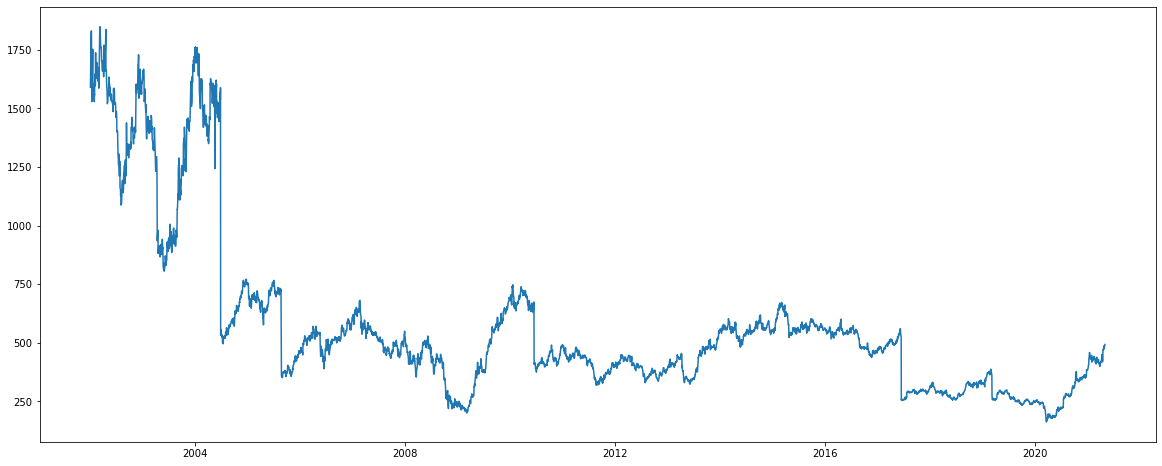

In [13]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(20,8))
plt.plot(df['Close'], label='Historical Close Price')

Selecting Close Price as feature and removing other columns from the data

In [15]:
features = ['Date','Prev Close', 'Close', 'VWAP', '%Deliverble',
       'EMA_9', 'SMA_50', 'SMA_100', 'SMA_200', 'RSI', 'absHC', 'absLC',
       'ATR', 'NATR', 'plusDI', 'minusDI', 'ADX', 'ROC']
all_data = df[features]

In [16]:
#setting index
all_data.index = all_data.Date
all_data.drop('Date', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
all_data.tail()

,Prev Close,Close,VWAP,%Deliverble,EMA_9,SMA_50,SMA_100,SMA_200,RSI,absHC,absLC,ATR,NATR,plusDI,minusDI,ADX,ROC
Date,,,,,,,,,,,,,,,,,
2021-04-26,475.70,480.30,479.77,0.3308,456.704306,430.168,413.5315,358.55550,70.827901,8.15,1.30,16.667857,3.470301,39.834774,13.626291,35.695045,12.442936
2021-04-27,480.30,485.05,484.07,0.3535,460.636922,431.068,414.8345,359.83250,69.986586,6.70,0.70,16.310714,3.362687,37.098465,11.809452,37.830026,10.742009
2021-04-28,485.05,489.30,487.55,0.3384,464.705768,431.982,416.1365,361.14225,70.491263,8.15,3.80,16.696429,3.412309,37.103162,10.234859,40.353809,10.676318
2021-04-29,489.30,489.85,489.45,0.3317,468.804807,432.988,417.5245,362.48075,68.340998,3.50,3.60,16.089286,3.284533,32.156073,8.870211,42.541088,8.831371
2021-04-30,489.85,492.75,501.42,0.1780,472.312339,434.045,418.8945,363.81950,68.069925,21.95,0.55,17.128571,3.476118,42.658700,7.687516,46.130462,13.904300


In [9]:
all_data.shape

(5306, 1)

In [18]:
#creating training and validation sets
dataset = all_data.values

train = dataset[2000:4500,:]
valid = dataset[4500:,:]

### Feature Scaling

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

### Creating Sliding Window of 90 days

This data structure is needed to cover 90-days close price stamps, based on which RNN will predict the 91st day's close price. 

In [20]:
x_train, y_train = [], []
for i in range(90,len(train)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#### Data Reshaping 

In [21]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Model Building

Initializing the LSTM model and 2nd, 3rd and 4th LSTM layer each with a Dropout Layer. The layers contain 50 neurons and with a Dropout rate of 20%, twenty percent of 50 neurons will be ignored randomly during each iteration

Finally, an output layer is added with 1 as an output dimension (as we are predicting the close price)

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(1))

Compiling the model with **Stochastic Gradient Descent** algorithm 

Using Mean Squared Error as Loss Function

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=500, batch_size=64, verbose=1)

Epoch 1/500
38/38 [==============================] - 8s 198ms/step - loss: 0.0223 - accuracy: 0.0000e+00
Epoch 2/500
38/38 [==============================] - 8s 200ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch 3/500
38/38 [==============================] - 8s 203ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 4/500
38/38 [==============================] - 8s 205ms/step - loss: 0.0047 - accuracy: 0.0000e+00
Epoch 5/500
38/38 [==============================] - 8s 203ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 6/500
38/38 [==============================] - 8s 203ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 7/500
38/38 [==============================] - 8s 207ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 8/500
38/38 [==============================] - 8s 204ms/step - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 9/500
38/38 [==============================] - 8s 200ms/step - loss: 0.0038 - accuracy: 0.0000e+00
Epoch 10/500
38/38 [==============================] - 8

In [17]:
# test_loss, test_acc = model.evaluate_generator(test_gen, steps=1)
# print('test acc:', test_acc)
# print("test_loss:", test_loss)

### Preparing the Test data for prediction

In [18]:
#predicting test data values, using past 90 from the train data
inputs = all_data[len(all_data) - len(valid)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [19]:
#inputs

In [20]:
inputs.shape

(896, 1)

In [21]:
X_test = []
for i in range(90,inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

In [22]:
X_test

array([[0.0130927 , 0.01346935, 0.01346405, ..., 0.01767621, 0.01689107,
        0.01622264],
       [0.01346935, 0.01346405, 0.01374521, ..., 0.01689107, 0.01622264,
        0.01608471],
       [0.01346405, 0.01374521, 0.01374521, ..., 0.01622264, 0.01608471,
        0.01587251],
       ...,
       [0.01984064, 0.02019607, 0.02080084, ..., 0.03324633, 0.03373439,
        0.03423836],
       [0.02019607, 0.02080084, 0.02064169, ..., 0.03373439, 0.03423836,
        0.03468929],
       [0.02080084, 0.02064169, 0.02134725, ..., 0.03423836, 0.03468929,
        0.03474764]])

In [23]:
X_test.shape

(806, 90)

In [24]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

In [25]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit_generator(train_gen,
#                               steps_per_epoch=2,
#                               epochs=50,
#                               validation_data=val_gen,
#                              validation_steps=val_steps)

In [26]:
# test_loss, test_acc = model.evaluate_generator(test_gen, steps=1)
# print('test acc:', test_acc)
# print("test_loss:", test_loss)

In [27]:
#preds

### Calculating the RMSE to evaluate the model performance

In [28]:
rms=np.sqrt(np.mean(np.power((valid-preds),2)))
rms

86.68209659975828

In [29]:
#valid

### Plotting the output

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


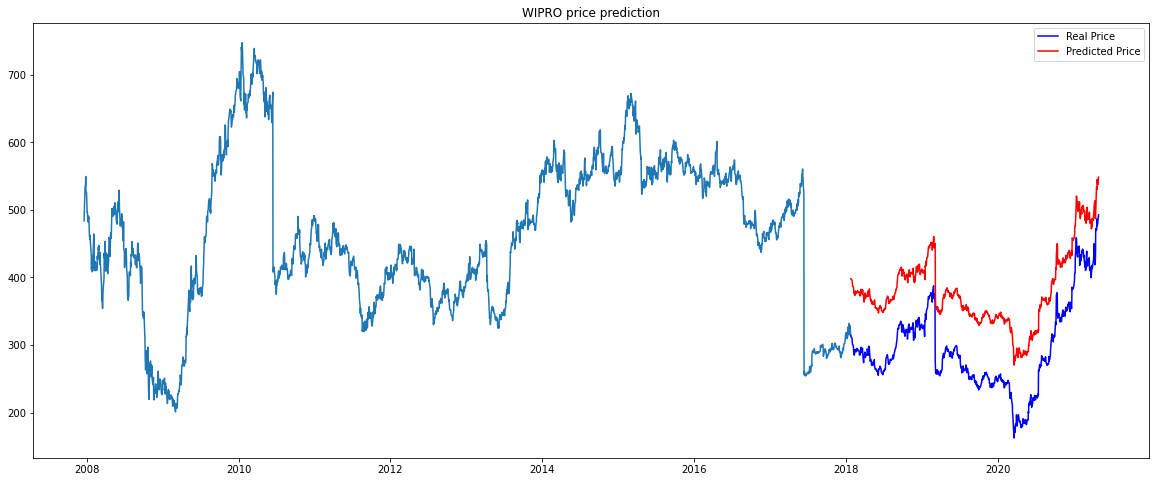

In [30]:
#for plotting
train = all_data[2000:4500]
valid = all_data[4500:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'blue', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Price')
plt.title('WIPRO price prediction')
plt.legend()
plt.show()

In [31]:

import altair as alt
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("RMSE of LSTM", np.sqrt(mean_squared_error(valid.Close, valid.Predictions)))
print("\nMAE of LSTM:", mean_absolute_error(valid.Close, valid.Predictions))

RMSE of LSTM 86.68209659975828

MAE of LSTM: 85.94680106113329
